# Predicción de precios de casas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import own library with custom technical routines
from custom_routines import custom_routines as cr

In [2]:
data = pd.read_csv("~/Desktop/mcc20192/mlearning/tareas/tarea3/data/housing.data", header=None, delim_whitespace=True)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311.0,15.2,386.71,17.10,18.9


## Estimador con regresión polinómica
Proponemos ajustar los datos con un modelo con 13 variables explicativas y una de respuesta (el precio de las casas). 

Buscamos usar un modelo de la forma
$$ f(\bar x) = a_0+\sum_{i=1}^{12} a_i\Phi(x_i),$$
donde $\Phi(x_i) = x_i +
Para usar mínimos cuadrados, la función de error asociada al modelo es: 
$$ E(a) = \frac{1}{2}\sum_{j=1}^{506} (y_j-f(\bar x^j)$$

Buscamos la tupla $a = (a_0,a_1,\dots, a_{12})$ que minimiza a $E$, la cual se obtiene con la siguiente fórmula: 

$$ a_{lsq} = (X^TX)^{-1}X^Ty,$$
donde $X$ es la matriz de $12\times 12$ con todos los valores de las variables dependientes, $X^T$ es su transpuesta, y $y$ es el vector de los valores de la variable respuesta. 

Debajo calculamos $a_{lsq}$. 

In [3]:
#gs = plt.GridSpec(5,3)
#fig = plt.figure(figsize=(16,16))
#for i in range(0,4): 
#    for j in range(0,3):
#        fig.add_subplot(gs[i,j]).plot(X[0:,(3*i)+j], y, 'ko', label = (3*i)+j)
#        plt.legend()
#fig.add_subplot(gs[4,0]).plot(X[0:,12], y, 'ko', label = 12)
#plt.legend()
#fig.add_subplot(gs[4,1]).plot(y, y, 'ko', label = 13)
#plt.legend()

In [105]:
# Function for crossvalidation
from sklearn.model_selection import train_test_split
def cvk(model, Matrix, k):
    cv_results = np.zeros(shape=(k,2))
    for i in range(0,k):
        train_set_i, test_set_i = train_test_split(Matrix, test_size = 0.30, random_state = i)
        X_i = train_set_i[0:,:-1]
        y_i = train_set_i[0:,-1]
        model.fit(X_i,y_i)
    
        # Training error
        cv_results[i][0] = cr.sqerror(model.predict(X_i),y_i)
    
        # Validation error
        Xv_i = test_set_i[0:,:-1]
        yv_i = test_set_i[0:,-1]
        cv_results[i][1] = cr.sqerror(model.predict(Xv_i),yv_i)
        
    return cv_results

### Fitting a polynomial model with no interactions

In [95]:
# Example of building model matrix using a polynomial expansion of degree d
d = 1
X = cr.modelMatrix(data.values[0:,:-1],d)
y = data.values[0:,-1]
print("Dim of X:", len(X),"x",len(X[0]))
from sklearn import linear_model
dmodel = linear_model.LinearRegression()
dmodel.fit(X,y)
cvk(dmodel, np.column_stack((X, y)), 10)

Dim of X: 506 x 14


array([[8.16979081, 7.63380199],
       [8.33371742, 7.31799603],
       [8.27026771, 7.46791365],
       [8.2860905 , 7.441219  ],
       [8.12445956, 7.73372888],
       [8.1241792 , 7.7548995 ],
       [8.14559299, 7.67457944],
       [8.23173712, 7.57986208],
       [8.24188045, 7.49689089],
       [8.31894586, 7.29061816]])

In [96]:
from sklearn import linear_model
dmodel = linear_model.LinearRegression()

# Look for best degree among 1 to 31
results = np.zeros(shape=(30,2))
for d in range(0,30):
    X = cr.modelMatrix(data.values[0:,:-1], d + 1)
    dmodel.fit(X,y)
    # Evaluation by cross-validation, k = 10
    a = cvk(dmodel, np.column_stack((X,y)), 10)
    
    results[d][0] = a[0:,0].mean()
    results[d][1] = a[0:,1].mean()
    # Evaluation by simple error on training set
    #results[d] = cr.sqerror(dmodel.predict(X),y)

Min Error on validation set 7.588787853280503 for degree  4
[7.58878785 7.34012332]


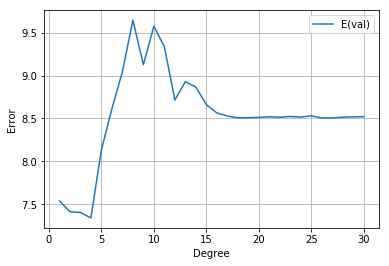

In [98]:
# Minimum error and degree among 1,...,31 that ensures it
print("Min Error on validation set", np.min(results[0:,0]), "for degree ", np.argmin(results[0:,1]) + 1)
print(results[3])

#plt.plot(np.arange(1,31), results)
#plt.plot(np.arange(1,31), results[0:,0], label = "E(train)")
plt.plot(np.arange(1,31), results[0:,1], label = "E(val)")
plt.legend()
plt.grid(True)
plt.ylabel("Error")
plt.xlabel("Degree")
plt.show()

### Fitting a polynomial model with interactions

In [99]:
from sklearn.preprocessing import PolynomialFeatures

In [104]:
dmodel = linear_model.LinearRegression(fit_intercept = False)#, normalize = True)

y = data.values[0:,-1]
results = np.zeros(shape=(7,2))
for d in range(0,7):
    poly = PolynomialFeatures(d+1)
    pX = poly.fit_transform(data.values[0:,:-1])
    print(len(pX),len(pX[0]))
    dmodel.fit(pX,y)
    
    # Evaluation by cross-validation, k = 10
    a = cvk(dmodel, np.column_stack((pX,y)), 10)
    
    results[d][0] = a[0:,0].mean()
    results[d][1] = a[0:,1].mean()
    print(results[d][0],results[d][1])
    
    #results[d] = cr.sqerror(dmodel.predict(pX),y)

    # Evaluation by cross-validation, k = 10
    #results[d] = cvk(dmodel, d + 1, 10).mean()
    # Evaluation by simple error on training set
    #results[d] = cr.sqerror(dmodel.predict(X),y)

506 14
8.224666161124663 7.539150961442338
506 105
6.789690374018844 7.221284970421822
506 560
-31.58833307198295 14.654823876824533
506 2380
-39.10722431612345 15.174834986516444
506 8568
-38.75609540930903 14.997475783034366
506 27132
-38.49250138412809 15.34897079890427
506 77520
-38.28381999189183 15.451992027043554


Min Error: 7.221284970421822 for degree  2
[6.78969037 7.22128497]


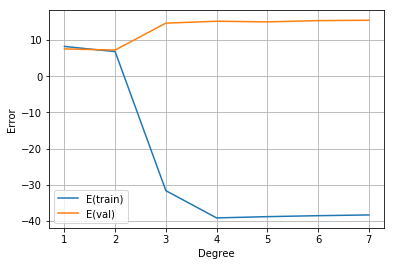

In [106]:
# Minimum error and degree among 1,...,8 that ensures it
print("Min Error:", np.min(results[0:,1]), "for degree ", np.argmin(results[0:,1]) + 1)
print(results[1])
#plt.plot(np.arange(1,7), results)
plt.plot(np.arange(1,8), results[0:,0], label = "E(train)")
plt.plot(np.arange(1,8), results[0:,1], label = "E(val)")
plt.legend()
plt.grid(True)
plt.ylabel("Error")
plt.xlabel("Degree")
plt.show()